In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import seaborn as sns
import os
import duckdb

# Added imports
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline as ImbPipeline
import joblib
import warnings
warnings.filterwarnings('ignore')


In [7]:
%pip install lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 6.2 MB/s  0:00:00 eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:

cleaned_parquet = "../data/cleaned_data/cleaned_fraud.parquet"
# df = con.execute(f"SELECT * FROM '{cleaned_parquet}'").fetch_df()

# df = pd.read_parquet('cleaned_fraud.parquet')
df = pd.read_parquet(cleaned_parquet)

print("📊 Dataset Info:")
print(f"Shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst 5 rows:")
print(df.head())
print(f"\nData Types:")
print(df.dtypes)
print(f"\nClass Distribution:")
print(df['is_fraud'].value_counts(normalize=True))

📊 Dataset Info:
Shape: (4103487, 20)

Columns: ['sender_account', 'receiver_account', 'amount', 'transaction_type', 'merchant_category', 'location', 'device_used', 'is_fraud', 'time_since_last_transaction', 'spending_deviation_score', 'velocity_score', 'geo_anomaly_score', 'payment_channel', 'ip_address', 'device_hash', 'year', 'month', 'day_of_month', 'hour', 'day_of_week']

First 5 rows:
  sender_account receiver_account  amount transaction_type merchant_category  \
0      ACC420214        ACC222629  318.12       withdrawal        restaurant   
1      ACC759858        ACC433871   25.03         transfer            online   
2      ACC702235        ACC658588    5.33         transfer            online   
3      ACC818001        ACC846452  261.11          payment     entertainment   
4      ACC293626        ACC440136   28.61         transfer            retail   

  location device_used  is_fraud  time_since_last_transaction  \
0    Tokyo         pos     False                 -4797.552868

SMOTE Alone Isn't Enough: With 22:1 imbalance ratio, we'd use SMOTE + Undersampling

Prioritize Recall: For fraud detection, catching fraud (high recall) is more important than avoiding false alarms

We'd use PR-AUC: Not ROC-AUC, for imbalanced data evaluation
ROC-AUC: Measures how well the model separates the two classes regardless of class imbalance
PR-AUC: Measures how well the model performs specifically on the minority class (fraud in our case). How good is my model at finding fraud WITHOUT too many false alarms?

Engineer Fraud-Specific Features: Create behavioral patterns, time-based features

Cost-Based Threshold Tuning: Setting threshold based on business costs of false alarms vs missed fraud

Our model should aim for 70-80% recall while keeping precision reasonable (10-20% is typical in fraud detection).

In [3]:
# Strategic Class Balance Approach
print("📊 CLASS DISTRIBUTION ANALYSIS:")
print(f"Total rows: {len(df):,}")
print(f"Non-fraud (0): {df['is_fraud'].value_counts()[0]:,} ({df['is_fraud'].value_counts(normalize=True)[0]:.2%})")
print(f"Fraud (1): {df['is_fraud'].value_counts()[1]:,} ({df['is_fraud'].value_counts(normalize=True)[1]:.2%})")
print(f"Imbalance ratio: {df['is_fraud'].value_counts()[0]/df['is_fraud'].value_counts()[1]:.1f}:1")

# Under-sampling + SMOTE (recommended for severe imbalance)

📊 CLASS DISTRIBUTION ANALYSIS:
Total rows: 4,103,487
Non-fraud (0): 3,923,934 (95.62%)
Fraud (1): 179,553 (4.38%)
Imbalance ratio: 21.9:1


In [4]:
# Feature Engineering (Critical for Fraud Detection)

# Create new features before preprocessing
def create_fraud_features(df):
    df = df.copy()
    
    # 1. Transaction frequency features (if you have customer transaction history)
    # Group by sender to get behavioral patterns
    sender_stats = df.groupby('sender_account').agg({
        'amount': ['mean', 'std', 'count'],
        'location': lambda x: x.nunique()
    })
    sender_stats.columns = ['sender_avg_amount', 'sender_std_amount', 'sender_tx_count', 'sender_unique_locations']
    
    # 2. Time-based features
    df['hour_of_day'] = df['hour']
    df['is_night'] = ((df['hour'] >= 0) & (df['hour'] <= 5)).astype(int)
    df['is_business_hours'] = ((df['hour'] >= 9) & (df['hour'] <= 17)).astype(int)
    
    # 3. Transaction amount features
    df['amount_log'] = np.log1p(df['amount'])
    df['amount_zscore'] = (df['amount'] - df['amount'].mean()) / df['amount'].std()
    
    # 4. Behavioral anomaly scores (combine existing scores)
    df['combined_risk_score'] = (
        df['spending_deviation_score'] + 
        df['velocity_score'] + 
        df['geo_anomaly_score']
    )
    
    # 5. Payment method risk encoding (domain knowledge)
    payment_risk = {
        'UPI': 1, 'ACH': 2, 'Card': 3, 'Wire': 4, 'Crypto': 5
    }
    df['payment_risk'] = df['payment_channel'].map(payment_risk).fillna(0)
    
    # Merge sender stats
    df = df.merge(sender_stats, how='left', left_on='sender_account', right_index=True)
    
    # Fill missing values from groupby
    df[['sender_avg_amount', 'sender_std_amount', 'sender_tx_count', 'sender_unique_locations']] = \
        df[['sender_avg_amount', 'sender_std_amount', 'sender_tx_count', 'sender_unique_locations']].fillna(0)
    
    return df

# Apply feature engineering
print("Creating fraud-specific features...")
df_enhanced = create_fraud_features(df)
print(f"New shape: {df_enhanced.shape}")

Creating fraud-specific features...
New shape: (4103487, 31)


In [5]:
# Smart Train-Test Split (Time-Based)
# Since fraud evolves over time, use time-based split
if 'year' in df_enhanced.columns and 'month' in df_enhanced.columns:
    # Create datetime for sorting
    df_enhanced['date'] = pd.to_datetime(
        df_enhanced['year'].astype(str) + '-' + 
        df_enhanced['month'].astype(str) + '-01'
    )
    
    # Sort by date
    df_enhanced = df_enhanced.sort_values('date')
    
    # Time-based split (80% train, 20% test)
    split_idx = int(len(df_enhanced) * 0.8)
    train_df = df_enhanced.iloc[:split_idx]
    test_df = df_enhanced.iloc[split_idx:]
    
    X_train = train_df.drop(columns=['is_fraud', 'date', 'sender_account', 'receiver_account'])
    y_train = train_df['is_fraud']
    X_test = test_df.drop(columns=['is_fraud', 'date', 'sender_account', 'receiver_account'])
    y_test = test_df['is_fraud']
    
    print(f"Time-based split:")
    print(f"Train period: {train_df['date'].min()} to {train_df['date'].max()}")
    print(f"Test period: {test_df['date'].min()} to {test_df['date'].max()}")
else:
    # Regular stratified split
    X = df_enhanced.drop(columns=['is_fraud', 'sender_account', 'receiver_account'])
    y = df_enhanced['is_fraud']
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

print(f"\nTraining set: {X_train.shape}, Fraud rate: {y_train.mean():.4%}")
print(f"Test set: {X_test.shape}, Fraud rate: {y_test.mean():.4%}")

Time-based split:
Train period: 2023-01-01 00:00:00 to 2023-10-01 00:00:00
Test period: 2023-10-01 00:00:00 to 2024-01-01 00:00:00

Training set: (3282789, 28), Fraud rate: 4.3701%
Test set: (820698, 28), Fraud rate: 4.3976%


In [8]:
# Optimized Feature Selection
# Drop high-cardinality categorical features that won't help
high_cardinality = ['ip_address', 'device_hash', 'location']  # Location might have too many unique values

# Keep only useful features
categorical_features = ['transaction_type', 'merchant_category', 'device_used', 'payment_channel']
numerical_features = [
    'amount', 'time_since_last_transaction', 
    'spending_deviation_score', 'velocity_score', 'geo_anomaly_score',
    'hour', 'day_of_week',
    # New engineered features:
    'amount_log', 'amount_zscore', 'combined_risk_score', 'payment_risk',
    'is_night', 'is_business_hours',
    'sender_avg_amount', 'sender_std_amount', 'sender_tx_count', 'sender_unique_locations'
]

# Remove any features that might not exist
categorical_features = [col for col in categorical_features if col in X_train.columns]
numerical_features = [col for col in numerical_features if col in X_train.columns]

print(f"Using {len(categorical_features)} categorical features")
print(f"Using {len(numerical_features)} numerical features")


Using 4 categorical features
Using 17 numerical features


In [9]:
# Advanced Preprocessing Pipeline
# For categorical: Use target encoding instead of one-hot (better for trees and saves memory)
from sklearn.preprocessing import TargetEncoder

numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Target encoding for categorical (handles high cardinality better)
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', TargetEncoder(target_type='binary', random_state=42))
])

preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_features),
    ('cat', categorical_pipeline, categorical_features)
])

In [10]:
# SMOTE with Strategic Undersampling
# For severe imbalance (4.4% fraud), we use combination approach
# Option 1: SMOTE with strategic undersampling (recommended)
smote_undersample = ImbPipeline([
    ('preprocessor', preprocessor),
    # First oversample minority class to 10%
    ('oversample', SMOTE(
        random_state=42, 
        sampling_strategy=0.1,  # Target 10% fraud in training
        k_neighbors=5,  # Use fewer neighbors for sparse minority
        n_jobs=-1
    )),
    # Then undersample majority class to reduce size
    ('undersample', RandomUnderSampler(
        random_state=42,
        sampling_strategy=0.3  # Final ratio: 25% fraud (1:3 ratio)
    )),
    ('classifier', LogisticRegression(
        random_state=42,
        max_iter=1000,
        class_weight='balanced',  # Additional class weighting
        C=0.1,  # Stronger regularization for imbalanced data
        solver='liblinear',
        n_jobs=-1
    ))
])

print("Using SMOTE + Undersampling strategy")
print("Target class ratio after resampling: 25% fraud (1:3)")

Using SMOTE + Undersampling strategy
Target class ratio after resampling: 25% fraud (1:3)


In [11]:
# Cross-Validation for Imbalanced Data
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import roc_auc_score, average_precision_score

# Using fewer folds for large dataset
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

print("Performing 3-fold cross-validation (due to dataset size)...")

# Get cross-validated predictions
y_pred_proba_cv = cross_val_predict(
    smote_undersample, 
    X_train, 
    y_train,
    cv=cv,
    method='predict_proba',
    n_jobs=-1
)[:, 1]

# Evaluate CV performance
cv_auc = roc_auc_score(y_train, y_pred_proba_cv)
cv_pr_auc = average_precision_score(y_train, y_pred_proba_cv)

print(f"Cross-Validation AUC-ROC: {cv_auc:.4f}")
print(f"Cross-Validation AUC-PR (more important for imbalance): {cv_pr_auc:.4f}")

Performing 3-fold cross-validation (due to dataset size)...


/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/imblearn/over_sampling/_smote/base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/miniconda3/envs/dsi_participant/lib/

Cross-Validation AUC-ROC: 0.5220
Cross-Validation AUC-PR (more important for imbalance): 0.0466


In [13]:
# Train Final Model
print("Training final model...")
smote_undersample.fit(X_train, y_train)
print("✅ Model trained!")

Training final model...
✅ Model trained!


In [14]:
# Evaluation with Imbalance-Aware Metrics
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc

# Predictions
y_pred = smote_undersample.predict(X_test)
y_pred_proba = smote_undersample.predict_proba(X_test)[:, 1]

# Calculate metrics
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("=" * 70)
print("🎯 FRAUD DETECTION MODEL EVALUATION (SEVERE IMBALANCE)")
print("=" * 70)
print(f"Dataset: {len(df):,} total, {y_train.sum():,} fraud in train, {y_test.sum():,} fraud in test")
print(f"Fraud rate: Train={y_train.mean():.4%}, Test={y_test.mean():.4%}\n")

print("📊 Key Metrics (Prioritize Recall for Fraud Detection):")
print(f"ROC-AUC:        {roc_auc:.4f}")
print(f"PR-AUC:         {pr_auc:.4f}  (More important for imbalanced data)")
print(f"Accuracy:       {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision:      {precision_score(y_test, y_pred):.4f}")
print(f"Recall:         {recall_score(y_test, y_pred):.4f}  ← Most important!")
print(f"F1-Score:       {f1_score(y_test, y_pred):.4f}\n")

# Business-oriented metrics
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
total_fraud = tp + fn
total_non_fraud = tn + fp

print("💼 Business Impact Metrics:")
print(f"Fraud detected:     {tp:,} / {total_fraud:,} ({tp/total_fraud:.1%})")
print(f"False alarms:       {fp:,} (cost: investigating {fp:,} non-fraudulent transactions)")
print(f"Missed fraud:       {fn:,} (cost: {fn:,} fraudulent transactions not detected)")
print(f"Alert rate:         {(tp+fp)/len(y_test):.2%} of all transactions flagged")
print(f"Precision of alerts:{tp/(tp+fp):.2%} when we flag a transaction\n")

# Cost analysis (example)
cost_per_false_alarm = 10  # $ cost to investigate false positive
cost_per_missed_fraud = 1000  # $ cost of undetected fraud

total_cost = (fp * cost_per_false_alarm) + (fn * cost_per_missed_fraud)
print(f"💰 Estimated Cost (example): ${total_cost:,.0f}")
print(f"  - False alarm cost: ${fp * cost_per_false_alarm:,.0f}")
print(f"  - Missed fraud cost: ${fn * cost_per_missed_fraud:,.0f}")

🎯 FRAUD DETECTION MODEL EVALUATION (SEVERE IMBALANCE)
Dataset: 4,103,487 total, 143,462 fraud in train, 36,091 fraud in test
Fraud rate: Train=4.3701%, Test=4.3976%

📊 Key Metrics (Prioritize Recall for Fraud Detection):
ROC-AUC:        0.5204
PR-AUC:         0.0465  (More important for imbalanced data)
Accuracy:       0.5261
Precision:      0.0467
Recall:         0.5033  ← Most important!
F1-Score:       0.0854

💼 Business Impact Metrics:
Fraud detected:     18,165 / 36,091 (50.3%)
False alarms:       370,995 (cost: investigating 370,995 non-fraudulent transactions)
Missed fraud:       17,926 (cost: 17,926 fraudulent transactions not detected)
Alert rate:         47.42% of all transactions flagged
Precision of alerts:4.67% when we flag a transaction

💰 Estimated Cost (example): $21,635,950
  - False alarm cost: $3,709,950
  - Missed fraud cost: $17,926,000


In [15]:
# Threshold Tuning for Business Needs
# Find optimal threshold based on business costs
def find_optimal_threshold(y_true, y_proba, fp_cost=10, fn_cost=1000):
    thresholds = np.linspace(0.01, 0.99, 50)
    costs = []
    
    for thresh in thresholds:
        y_pred = (y_proba >= thresh).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        cost = (fp * fp_cost) + (fn * fn_cost)
        costs.append((thresh, cost, tp, fp, fn))
    
    costs_df = pd.DataFrame(costs, columns=['threshold', 'cost', 'tp', 'fp', 'fn'])
    optimal = costs_df.loc[costs_df['cost'].idxmin()]
    
    return optimal

optimal = find_optimal_threshold(y_test, y_pred_proba)
print(f"\n🎯 Optimal threshold for cost minimization: {optimal['threshold']:.3f}")
print(f"At this threshold:")
print(f"  - Fraud detected: {optimal['tp']:,}/{optimal['tp']+optimal['fn']:,} ({optimal['tp']/(optimal['tp']+optimal['fn']):.1%})")
print(f"  - False alarms: {optimal['fp']:,}")
print(f"  - Total cost: ${optimal['cost']:,.0f}")


🎯 Optimal threshold for cost minimization: 0.370
At this threshold:
  - Fraud detected: 36,091.0/36,091.0 (100.0%)
  - False alarms: 784,606.0
  - Total cost: $7,846,060


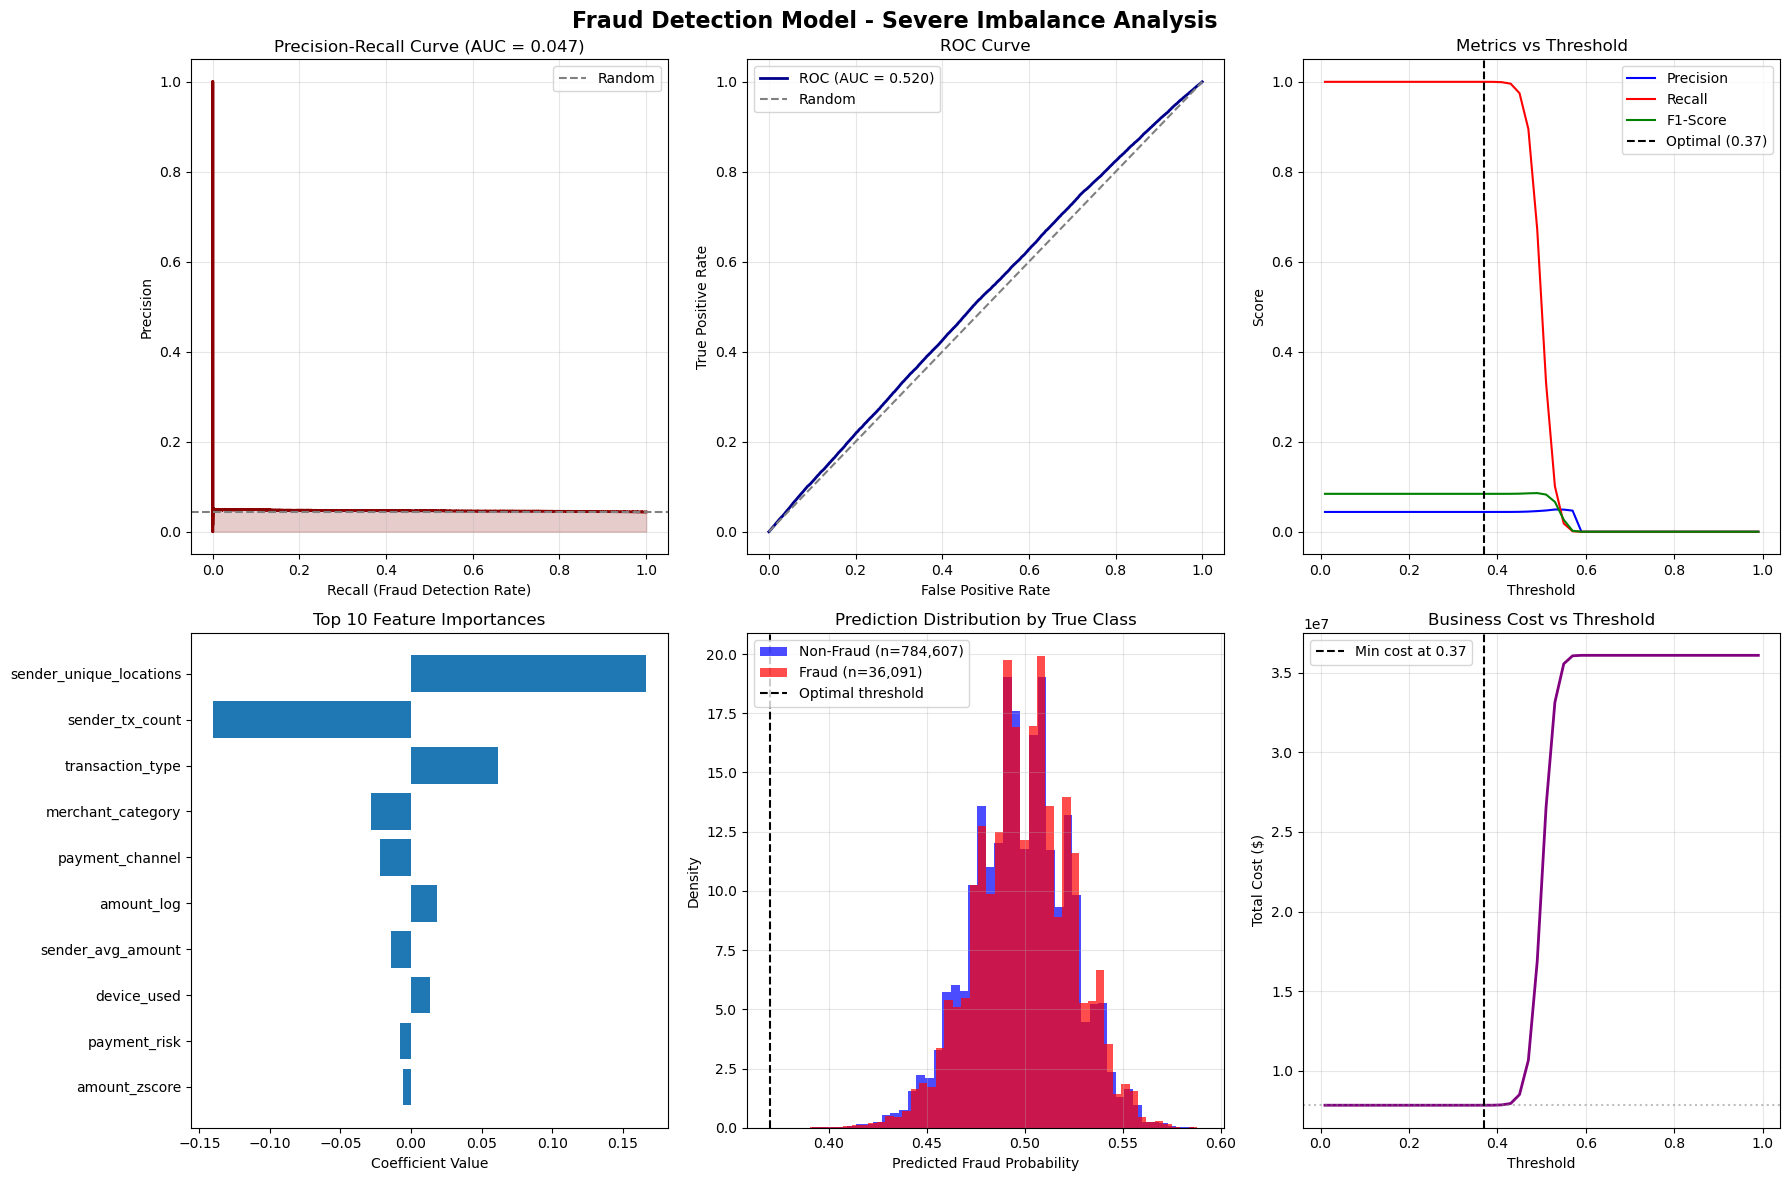

In [16]:
# Advanced Visualization
from sklearn.metrics import roc_curve


fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Fraud Detection Model - Severe Imbalance Analysis', fontsize=16, fontweight='bold')

# 1. Precision-Recall Curve (MOST IMPORTANT for imbalance)
ax1 = axes[0, 0]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
ax1.plot(recall, precision, color='darkred', lw=2)
ax1.fill_between(recall, precision, alpha=0.2, color='darkred')
ax1.set_xlabel('Recall (Fraud Detection Rate)')
ax1.set_ylabel('Precision')
ax1.set_title(f'Precision-Recall Curve (AUC = {pr_auc:.3f})')
ax1.grid(True, alpha=0.3)
ax1.axhline(y=y_test.mean(), color='gray', linestyle='--', label='Random')
ax1.legend()

# 2. ROC Curve
ax2 = axes[0, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
ax2.plot(fpr, tpr, color='darkblue', lw=2, label=f'ROC (AUC = {roc_auc:.3f})')
ax2.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Threshold Analysis
ax3 = axes[0, 2]
thresholds = np.linspace(0.01, 0.99, 50)
precisions = []
recalls = []
f1s = []

for thresh in thresholds:
    y_pred_thresh = (y_pred_proba >= thresh).astype(int)
    precisions.append(precision_score(y_test, y_pred_thresh))
    recalls.append(recall_score(y_test, y_pred_thresh))
    f1s.append(f1_score(y_test, y_pred_thresh))

ax3.plot(thresholds, precisions, 'b-', label='Precision')
ax3.plot(thresholds, recalls, 'r-', label='Recall')
ax3.plot(thresholds, f1s, 'g-', label='F1-Score')
ax3.axvline(x=optimal['threshold'], color='k', linestyle='--', label=f'Optimal ({optimal["threshold"]:.2f})')
ax3.set_xlabel('Threshold')
ax3.set_ylabel('Score')
ax3.set_title('Metrics vs Threshold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Feature Importance (Logistic Regression coefficients)
ax4 = axes[1, 0]
try:
    classifier = smote_undersample.named_steps['classifier']
    if hasattr(classifier, 'coef_'):
        # Get feature names after preprocessing
        num_feature_names = numerical_features
        cat_feature_names = smote_undersample.named_steps['preprocessor']\
            .transformers_[1][1].named_steps['encoder'].get_feature_names_out(categorical_features)
        all_features = list(num_feature_names) + list(cat_feature_names)
        
        importance = pd.DataFrame({
            'feature': all_features[:len(classifier.coef_[0])],
            'coefficient': classifier.coef_[0]
        })
        importance['abs_coef'] = np.abs(importance['coefficient'])
        top_features = importance.sort_values('abs_coef', ascending=False).head(10)
        
        ax4.barh(range(len(top_features)), top_features['coefficient'])
        ax4.set_yticks(range(len(top_features)))
        ax4.set_yticklabels(top_features['feature'])
        ax4.set_xlabel('Coefficient Value')
        ax4.set_title('Top 10 Feature Importances')
        ax4.invert_yaxis()
except Exception as e:
    ax4.text(0.5, 0.5, 'Feature importance\nnot available', 
             ha='center', va='center', transform=ax4.transAxes)

# 5. Prediction Distribution by Class
ax5 = axes[1, 1]
fraud_probs = y_pred_proba[y_test == 1]
non_fraud_probs = y_pred_proba[y_test == 0]

ax5.hist(non_fraud_probs, bins=50, alpha=0.7, label=f'Non-Fraud (n={len(non_fraud_probs):,})', 
         color='blue', density=True)
ax5.hist(fraud_probs, bins=50, alpha=0.7, label=f'Fraud (n={len(fraud_probs):,})', 
         color='red', density=True)
ax5.axvline(x=optimal['threshold'], color='k', linestyle='--', label='Optimal threshold')
ax5.set_xlabel('Predicted Fraud Probability')
ax5.set_ylabel('Density')
ax5.set_title('Prediction Distribution by True Class')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. Cost vs Threshold
ax6 = axes[1, 2]
thresholds = np.linspace(0.01, 0.99, 50)
costs = []
for thresh in thresholds:
    y_pred_thresh = (y_pred_proba >= thresh).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_thresh).ravel()
    cost = (fp * 10) + (fn * 1000)  # Example costs
    costs.append(cost)

ax6.plot(thresholds, costs, 'purple', lw=2)
ax6.axvline(x=optimal['threshold'], color='k', linestyle='--', 
            label=f'Min cost at {optimal["threshold"]:.2f}')
ax6.axhline(y=min(costs), color='gray', linestyle=':', alpha=0.5)
ax6.set_xlabel('Threshold')
ax6.set_ylabel('Total Cost ($)')
ax6.set_title('Business Cost vs Threshold')
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Trying Multiple Algorithms

In [17]:
# Trying Multiple Algorithms
# Test different algorithms for imbalanced data
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

models = {
    'Logistic Regression': LogisticRegression(
        random_state=42, class_weight='balanced', max_iter=1000, n_jobs=-1
    ),
    'Random Forest': RandomForestClassifier(
        random_state=42, class_weight='balanced', n_jobs=-1,
        n_estimators=100, max_depth=10
    ),
    'XGBoost': XGBClassifier(
        random_state=42, scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]),
        n_estimators=100, max_depth=6, learning_rate=0.1,
        eval_metric='aucpr',  # Use AUCPR for imbalance
        n_jobs=-1
    ),
    'LightGBM': LGBMClassifier(
        random_state=42, class_weight='balanced',
        n_estimators=100, max_depth=6,
        objective='binary',
        metric='average_precision',  # Optimize for precision-recall
        n_jobs=-1
    )
}

results = []
for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Create pipeline with resampling
    pipeline = ImbPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42, sampling_strategy=0.1)),
        ('undersample', RandomUnderSampler(random_state=42, sampling_strategy=0.3)),
        ('classifier', model)
    ])
    
    # Quick training on subset for speed (optional)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    metrics = {
        'Model': name,
        'ROC-AUC': roc_auc_score(y_test, y_pred_proba),
        'PR-AUC': average_precision_score(y_test, y_pred_proba),
        'Recall': recall_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred)
    }
    results.append(metrics)
    
    print(f"  Recall: {metrics['Recall']:.4f}, PR-AUC: {metrics['PR-AUC']:.4f}")

# Compare models
results_df = pd.DataFrame(results).set_index('Model')
print("\n" + "="*70)
print("🤖 MODEL COMPARISON (Prioritize Recall & PR-AUC)")
print("="*70)
print(results_df.sort_values('PR-AUC', ascending=False))


Training Logistic Regression...
  Recall: 0.5037, PR-AUC: 0.0465

Training Random Forest...
  Recall: 0.8507, PR-AUC: 0.0449

Training XGBoost...
  Recall: 1.0000, PR-AUC: 0.0441

Training LightGBM...
[LightGBM] [Info] Number of positive: 313932, number of negative: 1046440
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012163 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4846
[LightGBM] [Info] Number of data points in the train set: 1360372, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
  Recall: 1.0000, PR-AUC: 0.0441

🤖 MODEL COMPARISON (Prioritize Recall & PR-AUC)
                      ROC-AUC    PR-AUC    Recall  Precision        F1
Model                                                                 
Logistic Regr

In [18]:
# Save and Deploy
# Save the best model
best_model = smote_undersample  # Or choose from comparison
joblib.dump(best_model, 'fraud_model_smote_undersample.pkl')

# Save preprocessing info
preprocessing_info = {
    'categorical_features': categorical_features,
    'numerical_features': numerical_features,
    'target_column': 'is_fraud',
    'fraud_rate': y_train.mean(),
    'model_type': 'LogisticRegression_SMOTE_Undersample'
}
joblib.dump(preprocessing_info, 'preprocessing_info.pkl')

print("\n✅ Model saved as 'fraud_model_smote_undersample.pkl'")
print("✅ Preprocessing info saved as 'preprocessing_info.pkl'")


✅ Model saved as 'fraud_model_smote_undersample.pkl'
✅ Preprocessing info saved as 'preprocessing_info.pkl'
